# Group Number:
# Student 1:
# Student 2:
# Student 3:

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/TUe/DeepLearning"

In [2]:
""" # # UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content) """

' # # UNCOMMENT IF USING COLAB\nfrom google.colab import drive\nimport requests\ndrive.mount(\'/content/drive\')\nimport sys\nimport os\nsys.path.insert(0, notebook_dir) \nos.chdir(notebook_dir)\nsymco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"\ncrpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"\nr_s = requests.get(symco, allow_redirects=True)\nr_c = requests.get(crpt, allow_redirects=True)\nwith open(\'symconv.py\', \'wb\') as f:\n    f.write(r_s.content)\nwith open(\'carpet.py\', \'wb\') as f:\n    f.write(r_c.content) '

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

In [3]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [4]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


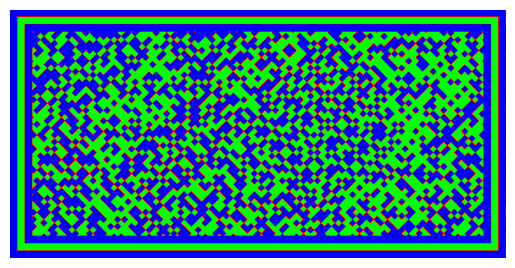

In [5]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
class SymModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.rot_slc = sc.Slice(rotation=4, reflection=False)
        self.convs = nn.Sequential(
            sc.SymmetryConv2d(in_filters=1, out_filters=16, kernel_size=4, stride=4, rotation=4, reflection=False),
            nn.ReLU(),
            sc.SymmetryPool(),
            nn.Conv2d(16, 32, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU()
            )
        self.pool = sc.SymmetryPool()
        self.lin1 = nn.Linear(576, 64)
        self.lin2 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.rot_slc(x)
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.lin1(torch.flatten(x, start_dim=1))
        x = self.lin2(x)

        return x

In [8]:
model = SymModel().to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [11]:
EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    
    model.train()
    
    train_losses = []

    train_acc, train_count = 0, 0

    for batch in train_dataloader:
        x, y = batch
        input, labels = x.to(device), y.to(device)
        optimizer.zero_grad()

        output = model(input)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        train_acc += (labels.argmax(dim=-1) == output.argmax(dim=-1)).sum().item()

        train_count += labels.size(0)

    model.eval()

    valid_acc, valid_count = 0, 0


    for batch in valid_dataloader:

        x, y = batch
        input, labels = x.to(device), y.to(device)

        with torch.no_grad():
            output = model(input)
            
            valid_acc += (labels.argmax(dim=-1) == output.argmax(dim=-1)).sum().item()

            valid_count += labels.size(0)



    print(f'Train acc: {train_acc / train_count:.4f}',end=' ')
    print(f'Val acc: {valid_acc / valid_count:.4f}',end='\n')

 10%|█         | 1/10 [00:10<01:30, 10.08s/it]

Train acc: 0.9759 Val acc: 0.9825


 20%|██        | 2/10 [00:19<01:19,  9.98s/it]

Train acc: 0.9885 Val acc: 0.9910


 30%|███       | 3/10 [00:29<01:09,  9.97s/it]

Train acc: 0.9949 Val acc: 0.9915


 40%|████      | 4/10 [00:40<01:00, 10.01s/it]

Train acc: 0.9972 Val acc: 0.9905


 50%|█████     | 5/10 [00:49<00:49,  9.98s/it]

Train acc: 0.9989 Val acc: 0.9940


 60%|██████    | 6/10 [01:00<00:40, 10.03s/it]

Train acc: 0.9997 Val acc: 0.9935


 70%|███████   | 7/10 [01:10<00:30, 10.04s/it]

Train acc: 1.0000 Val acc: 0.9945


 80%|████████  | 8/10 [01:20<00:20, 10.07s/it]

Train acc: 1.0000 Val acc: 0.9935


 90%|█████████ | 9/10 [01:30<00:10, 10.11s/it]

Train acc: 1.0000 Val acc: 0.9940


100%|██████████| 10/10 [01:40<00:00, 10.08s/it]

Train acc: 1.0000 Val acc: 0.9970


In [20]:
model_task1_state = model.state_dict()

## Task 1: Question 5d

# Task 2: Carpet Matching 

In [75]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [76]:
#Stratify split into train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

#convert to tensors
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()

#### Defining the Embedding Net. Using the same network from Task 1 ## 

In [290]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.rot_slc = sc.Slice(rotation=4, reflection=False)
        self.convs = nn.Sequential(
            sc.SymmetryConv2d(in_filters=1, out_filters=16, kernel_size=4, stride=4, rotation=4, reflection=False),
            nn.ReLU(),
            sc.SymmetryPool(),
            nn.Conv2d(16, 32, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU()
            )
        self.pool = sc.SymmetryPool()
        self.lin1 = nn.Linear(576, 64)  #second to last layer of model of task 1 to extract embeddings 
        # self.lin2 = nn.Linear(64, 3)
        
        
    def forward(self, x):
        x = self.rot_slc(x)
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.lin1(torch.flatten(x, start_dim=1))
        # x = self.lin2(x)

        return x
    
    def get_embedding(self, x):
        return self.forward(x)



In [291]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class Lambda(nn.Module):
#     def __init__(self, lambd):
#         super().__init__()
#         self.lambd = lambd

#     def forward(self, x):
#         return self.lambd(x)

# class EmbeddingNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.rot_slc = sc.Slice(rotation=4, reflection=False)
#         self.convs = nn.Sequential(
#             sc.SymmetryConv2d(in_filters=1, out_filters=16, kernel_size=4, stride=4, rotation=4, reflection=False),
#             nn.ReLU(),
#             sc.SymmetryPool(),
#             nn.Conv2d(16, 32, kernel_size=3, stride=3),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1),
#             nn.ReLU(),
#             # nn.Conv2d(64, 64, kernel_size=3, stride=1),
#             # nn.ReLU()
#         )
#         # self.pool = sc.SymmetryPool()
#         self.lin1 = nn.Linear(576, 265)  # Increase the output size of the linear layer
#         self.lin2 = nn.Linear(265, 128)   # Add another linear layer
#         # self.lin3 = nn.Linear(64, 3)    # Optionally, add more linear layers
        
#     def forward(self, x):
#         x = self.rot_slc(x)
#         x = self.convs(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.lin1(torch.flatten(x, start_dim=1))
#         x = self.lin2(x)
#         # x = self.lin3(x)
#         return x
    
#     def get_embedding(self, x):
#         return self.forward(x)

### Balanced Batch Sampler and Data Loader

In [292]:
from torch.utils.data.sampler import BatchSampler
import numpy as np

class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """
    #Just overriding a bunch of methods from BatchSampler

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [293]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [294]:
train_batch_sampler = BalancedBatchSampler(y_train, n_classes=200, n_samples=2)
test_batch_sampler = BalancedBatchSampler(y_val, n_classes=200, n_samples=2)

#train_dataset= torch.utils.data.TensorDataset(X_train,y_train)
#test_dataset= torch.utils.data.TensorDataset(X_val,y_val)
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_val, y_val)

triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)

### Random Triple Selector

In [295]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


### Triplets loss

In [296]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

            
        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1]  
        
        negative_idx= triplets[:, 2]  
            
            
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)
        # print("AP distances mean:", ap_distances.mean())
        # print(ap_distances)
        # print("AN distances mean:", an_distances.mean())
        # print(an_distances)
        # print(losses.mean())

        # Calculate statistics
        # std = torch.std(losses).item()
        # highest = torch.max(losses).item()
        # lowest = torch.min(losses).item()
        # q1 = torch.quantile(losses, 0.25).item()
        # q3 = torch.quantile(losses, 0.75).item()

        # print("Standard Deviation:", std)
        # print("Highest Value:", highest)
        # print("Lowest Value:", lowest)
        # print("Q1:", q1)
        # print("Q3:", q3)

        return losses.mean()

### Training the model

In [297]:
class Train():
    def __init__(self,
                 model: nn.Module,
                 device: torch.device,
                 criterion: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.DataLoader,
                 validation_DataLoader: torch.utils.data.DataLoader,
                 epochs: int,
                ):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.epochs = epochs

    def run_train(self):

        for epoch in tqdm(range(self.epochs)):

            self.model.train()

            train_losses = []
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)


                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')


In [313]:
if torch.cuda.is_available():
    device = torch.device('cuda')

else:
    device = torch.device('cpu')

model= EmbeddingNet().to(device)
# model_task1_state.pop("lin2.weight", None)
# model_task1_state.pop("lin2.bias", None)
# model.load_state_dict(model_task1_state)

criterion = TripletLoss(margin=10, triplet_selector=RandomTripletSelector())
optimizer = torch.optim.Adam(model.parameters())

trainer= Train(model=model,
               device=device,
               criterion=criterion,
               optimizer=optimizer,
               training_DataLoader=triplets_train_loader,
               validation_DataLoader=triplets_test_loader,
               epochs=10)

trainer.run_train()


 10%|█         | 1/10 [00:19<02:56, 19.61s/it]

EPOCH: 01/10 LOSS: 10.0046 VAL-LOSS: 9.9938


 20%|██        | 2/10 [00:38<02:32, 19.08s/it]

EPOCH: 02/10 LOSS: 10.0065 VAL-LOSS: 9.9768


 30%|███       | 3/10 [00:56<02:12, 18.88s/it]

EPOCH: 03/10 LOSS: 10.0060 VAL-LOSS: 10.0327


 40%|████      | 4/10 [01:19<02:01, 20.30s/it]

EPOCH: 04/10 LOSS: 9.9837 VAL-LOSS: 10.2864


 50%|█████     | 5/10 [01:41<01:44, 20.91s/it]

EPOCH: 05/10 LOSS: 10.0218 VAL-LOSS: 10.0119


 60%|██████    | 6/10 [02:00<01:21, 20.32s/it]

EPOCH: 06/10 LOSS: 10.0074 VAL-LOSS: 10.0203


 70%|███████   | 7/10 [02:19<00:59, 19.93s/it]

EPOCH: 07/10 LOSS: 9.9857 VAL-LOSS: 10.0112


 80%|████████  | 8/10 [02:38<00:39, 19.63s/it]

EPOCH: 08/10 LOSS: 9.9657 VAL-LOSS: 9.8434


 90%|█████████ | 9/10 [02:57<00:19, 19.48s/it]

EPOCH: 09/10 LOSS: 10.0509 VAL-LOSS: 9.9509


100%|██████████| 10/10 [03:17<00:00, 19.70s/it]

EPOCH: 10/10 LOSS: 9.9927 VAL-LOSS: 10.0166


### Extract the embeddings

In [315]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

def extract_embeddings(dataloader, model):
    
    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 64))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(train_loader, model)
val_embeddings, val_labels = extract_embeddings(test_loader, model)

### TSNE does not show any interesting pattern  

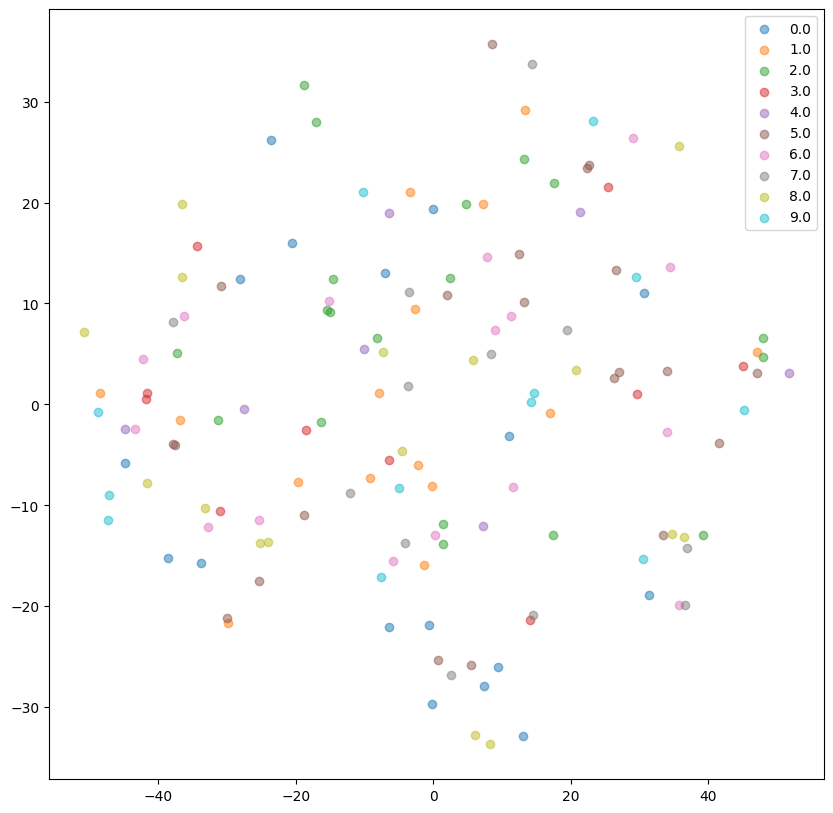

In [316]:
from sklearn.manifold import TSNE
def plot_tsne_embeddings(embeddings, targets, xlim=None, ylim=None):
    
    
    # The first 3000 embeddings and targets
    embeddings= embeddings[:3000]
    targets= targets[:3000]

    # Using Tsne to for dimension reduction 
    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(np.unique(targets))

plot_tsne_embeddings(train_embeddings, train_labels) 
#plot_tsne_embeddings(val_embeddings, val_labels)

In [317]:
#Helper function to compute Euclidean distance

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [318]:

class Informative_Negative_TripletSelector():

    def __init__(self, margin, loss_margin):
        super(Informative_Negative_TripletSelector, self).__init__()
  
        self.margin = margin
        self.loss_margin = loss_margin
  
   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):
        
        informative_negative = np.where(loss_values > self.loss_margin)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None


    def get_triplets(self, embeddings, labels):
        
        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []
           
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                
                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)
        
        return torch.LongTensor(triplets)
        

In [319]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device=torch.device('cpu')
    
# model
mined_embedding_net = EmbeddingNet()
mined_model = mined_embedding_net.to(device)


# margin value
margin=10

# criterion
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin, 0.2))

# optimizer
optimizer = torch.optim.Adam(model.parameters())

# trainer
trainer = Train(model=mined_model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_test_loader,
                  epochs=5)

# start training
trainer.run_train()

 20%|██        | 1/5 [00:20<01:22, 20.71s/it]

EPOCH: 1/5 LOSS: 9.9936 VAL-LOSS: 10.0192


 40%|████      | 2/5 [00:40<01:01, 20.37s/it]

EPOCH: 2/5 LOSS: 10.0077 VAL-LOSS: 10.0094


 60%|██████    | 3/5 [01:00<00:40, 20.22s/it]

EPOCH: 3/5 LOSS: 9.9804 VAL-LOSS: 10.0208


 80%|████████  | 4/5 [01:21<00:20, 20.20s/it]

EPOCH: 4/5 LOSS: 9.9987 VAL-LOSS: 9.9821


100%|██████████| 5/5 [01:41<00:00, 20.22s/it]

EPOCH: 5/5 LOSS: 9.9927 VAL-LOSS: 10.0079


In [320]:
# # device
# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     print('GPU is available')
# else:
#     device=torch.device('cpu')
    
# # train_embeddings, train_labels = extract_embeddings(train_loader, model)
# # val_embeddings, val_labels = extract_embeddings(test_loader, model)

# # model
# hard_mined_embedding_net = EmbeddingNet()
# hard_mined_model = hard_mined_embedding_net.to(device)


# # margin value
# margin=10

# # criterion
# criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin, 5))

# # optimizer
# optimizer = torch.optim.Adam(model.parameters())

# # trainer
# trainer = Train(model=hard_mined_model,
#                   device=device,
#                   criterion=criterion,
#                   optimizer=optimizer,
#                   training_DataLoader=triplets_train_loader,
#                   validation_DataLoader=triplets_test_loader,
#                   epochs=5)

# # start training
# trainer.run_train()

In [321]:
# Average Precision
def average_precision(sorted_class_vals, true_class):
    ind = sorted_class_vals == true_class
    num_positive = np.sum(ind)
    cum_ind = np.cumsum(ind).astype(np.float32)
    enum = np.array(range(1, len(ind)+1)).astype(np.float32)
    return np.sum(cum_ind * ind / enum) / num_positive

In [322]:
# function to determine performance of model
def query_performance(queries, targets, gt, model, top=1):
    assert top >= 1
    cnt = 0

    #convert to torch tensors
    queries= torch.tensor(queries)
    targets= torch.tensor(targets)

    q = queries.float()
    t = targets.float()

    with torch.no_grad():
        
        
        ### MODIFY IF NECESSARY ###
        #set model to evaluation mode
        model.eval()

        #For each query, compute embeddings for both query and 4 targets and store them in the most efficient way
        emb_q = model(q).cpu().numpy()
        emb_t=np.empty((len(queries),1,4,64)) #embedding shape
        for i in range(len(queries)):
            emb_t_ind=model(t[i]).cpu().numpy()
            emb_t_ind = np.expand_dims(emb_t_ind, axis=0)
            emb_t[i]=emb_t_ind
                
        for i in range(len(queries)):  
            dist = cdist(np.expand_dims(emb_q[i],axis=0), np.concatenate(emb_t[i]))
        
            if top == 1:
                pred = np.argmin(dist)

            if pred == gt[i]:
                cnt += 1
        
            else:
                pred = np.argsort(dist)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1

    return (100*cnt/gt.shape[0])

In [323]:
performance_mined = query_performance(queries, targets, gt, model = mined_model)

In [324]:
performance_mined 

61.666666666666664

In [325]:
performance = query_performance(queries, targets, gt, model)

In [326]:
performance

20.0